In [6]:
from riskeye.cogmodels.fit_model import build_model, get_data
import arviz as az
from riskeye.cogmodels.utils import plot_ppc
from bauer.utils.math import softplus_np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path as op

In [7]:
def get_info(model_label, bids_folder='/data/ds-riskeye'):
    df = get_data('/data/ds-riskeye', model_label)
    model = build_model(model_label, df)
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


    return df, model, idata

# Model 1

In [ ]:
df, model, idata = get_info('1')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_64972/685786403.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['n1_evidence_sd_mu'].to_dataframe().xs('exptype[T.symbolic]', 0, -1))


<Axes: ylabel='Density'>

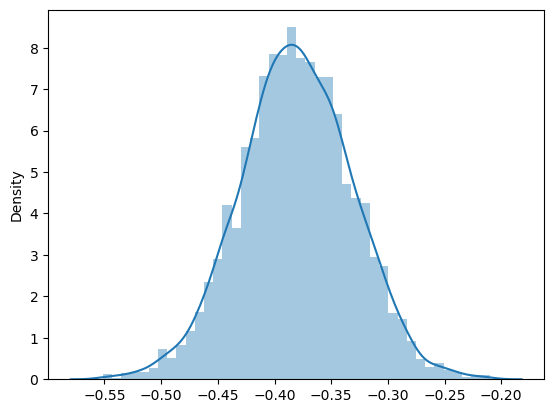

In [26]:
sns.distplot(idata.posterior['n1_evidence_sd_mu'].to_dataframe().xs('exptype[T.symbolic]', 0, -1))

In [27]:
traces = {}

pars_ns = []
pars_s = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    non_symbolic_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    symbolic_values = non_symbolic_values + traces[key].xs('exptype[T.symbolic]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        non_symbolic_values = softplus_np(non_symbolic_values)
        symbolic_values = softplus_np(symbolic_values)

    pars_ns.append(non_symbolic_values)
    pars_s.append(symbolic_values)


pars_ns = pd.concat(pars_ns, axis=1)
pars_s = pd.concat(pars_s, axis=1)

pars = pd.concat((pars_ns, pars_s), keys=['non-symbolic', 'symbolic'], names=['exptype'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


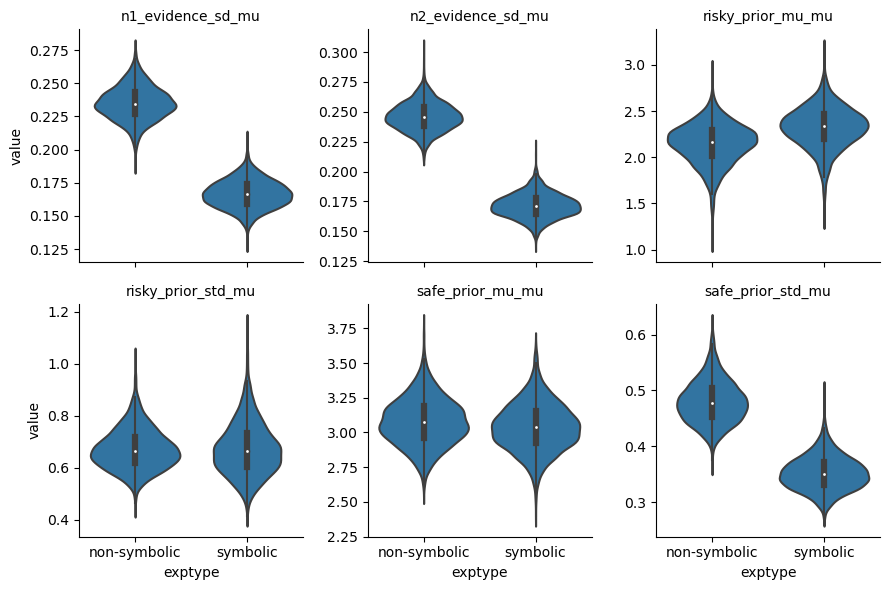

In [28]:
import seaborn as sns

g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'exptype', 'value', fill=True, col_wrap=3)
g.set_titles('{col_name}')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in s

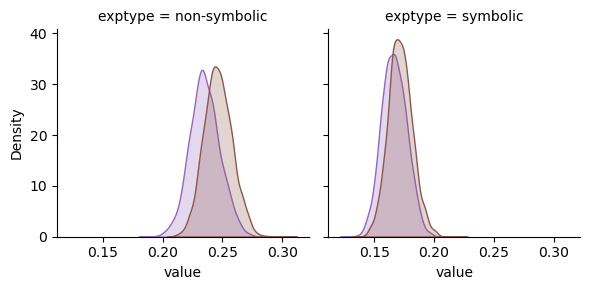

In [35]:
tmp = pars.query('parameter in ["n1_evidence_sd_mu", "n2_evidence_sd_mu"]')

g = sns.FacetGrid(tmp.reset_index(), col='exptype', hue='parameter', palette=sns.color_palette()[4:])
g.map(sns.kdeplot, 'value', shade=True)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


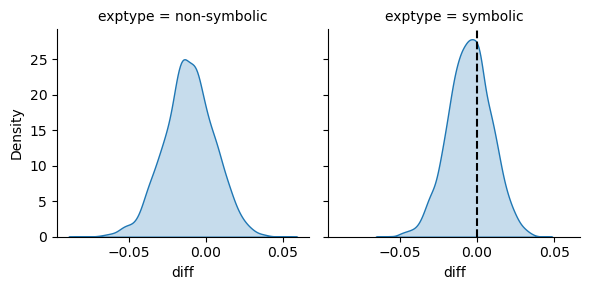

In [36]:
tmp = tmp.unstack('parameter').droplevel(0, 1)

diff = (tmp['n1_evidence_sd_mu'] - tmp['n2_evidence_sd_mu']).to_frame('diff')
diff
g = sns.FacetGrid(diff.reset_index(), col='exptype')
g.map(sns.kdeplot, 'diff', shade=True)

plt.axvline(0, color='k', linestyle='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_64972/3424181402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_mu['Option'] = prior_mu.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})


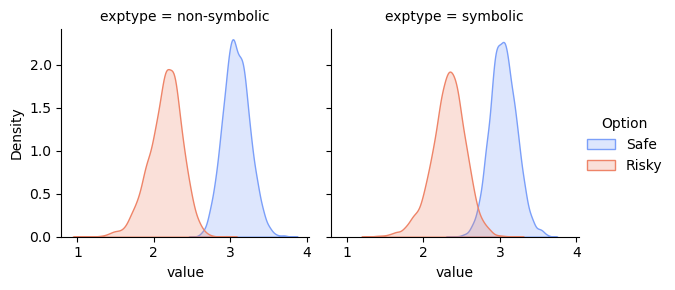

In [37]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

prior_mu = pars.query('parameter in ["risky_prior_mu_mu", "safe_prior_mu_mu"]')
prior_mu['Option'] = prior_mu.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})

g = sns.FacetGrid(prior_mu.reset_index(), col='exptype', hue='Option', palette=palette, hue_order=['Safe', 'Risky'])
g.map(sns.kdeplot, 'value', fill=True)
g.add_legend()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_64972/1911895864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_std['Option'] = prior_std.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})


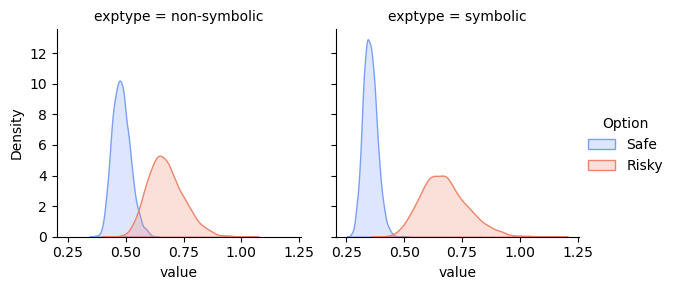

In [38]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

prior_std = pars.query('parameter in ["risky_prior_std_mu", "safe_prior_std_mu"]')
prior_std['Option'] = prior_std.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})

g = sns.FacetGrid(prior_std.reset_index(), col='exptype', hue='Option', palette=palette, hue_order=['Safe', 'Risky'])
g.map(sns.kdeplot, 'value', fill=True)
g.add_legend()

In [39]:
diff = tmp.unstack('parameter')['value']
diff = (diff['n1_evidence_sd_mu'] - diff['n2_evidence_sd_mu']).to_frame('diff')

g = sns.FacetGrid(diff.reset_index(), hue='exptype', palette=sns.color_palette()[-3:])
g.map(sns.kdeplot, 'diff', shade=True)
plt.axvline(0.0, c='k', ls='--')

KeyError: 'Level parameter not found'

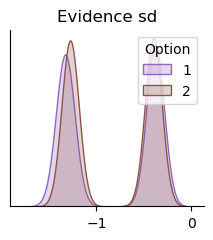

In [40]:
evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'n1_evidence_sd_mu':1, 'n2_evidence_sd_mu':2})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd')
# fac.add_legend()
plt.legend(title='Option')

# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_evidence_sd.pdf'), bbox_inches='tight')

In [41]:
model.build_estimation_model()
ppc = model.ppc(df, idata.sel(draw=slice(None, None, 20)))

Sampling: [ll_bernoulli]


In [43]:
ppc.loc[ppc.index.get_level_values('p1') == 0.55] = 1 - ppc.loc[ppc.index.get_level_values('p1') == 0.55]

In [44]:
from riskeye.cogmodels.utils import plot_ppc

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


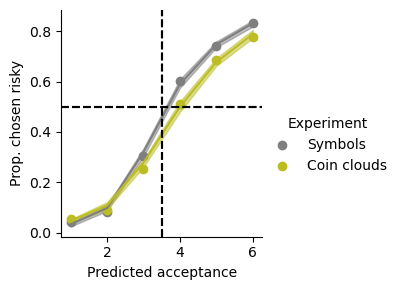

In [45]:
plot_ppc(df, ppc, level='group', plot_type=0)

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


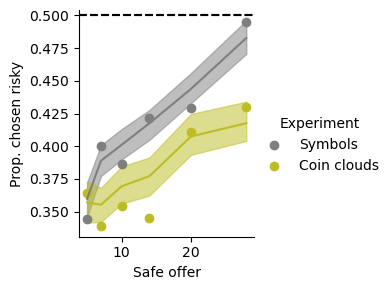

In [46]:
plot_ppc(df, ppc, level='group', plot_type=1)

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


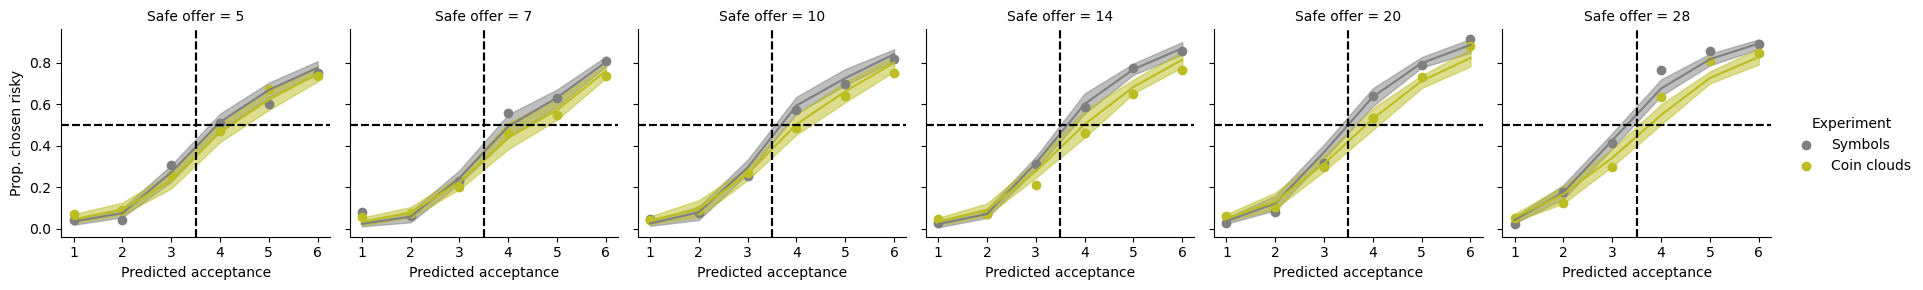

In [47]:
plot_ppc(df, ppc, level='group', plot_type=2)

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


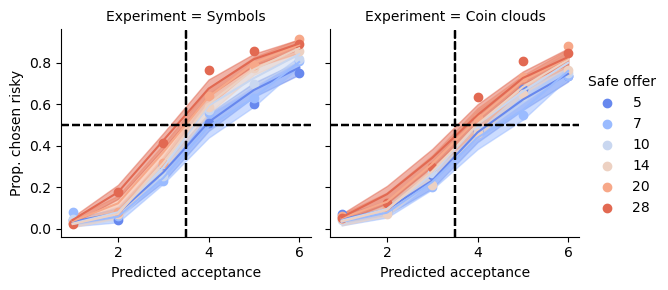

In [48]:
plot_ppc(df, ppc, level='group', plot_type=3)

In [22]:
traces = {}

pars_ns = []
pars_s = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}'].to_dataframe()

    non_symbolic_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    symbolic_values = non_symbolic_values + traces[key].xs('exptype[T.symbolic]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        non_symbolic_values = softplus_np(non_symbolic_values)
        symbolic_values = softplus_np(symbolic_values)

    pars_ns.append(non_symbolic_values)
    pars_s.append(symbolic_values)


pars_ns = pd.concat(pars_ns, axis=1)
pars_s = pd.concat(pars_s, axis=1)

pars = pd.concat((pars_ns, pars_s), keys=['non-symbolic', 'symbolic'], names=['exptype'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

value
exptype      chain draw subject parameter               
non-symbolic 0     0    01      n1_evidence_sd  0.186582
                                n2_evidence_sd  0.193697
                        02      n1_evidence_sd  0.172020
                                n2_evidence_sd  0.179418
                        03      n1_evidence_sd  0.180337
...                                                  ...
symbolic     3     26   62      n2_evidence_sd  0.099279
                        63      n1_evidence_sd  0.139303
                                n2_evidence_sd  0.118694
                        64      n1_evidence_sd  0.230042
                                n2_evidence_sd  0.238215

[20412 rows x 1 columns]

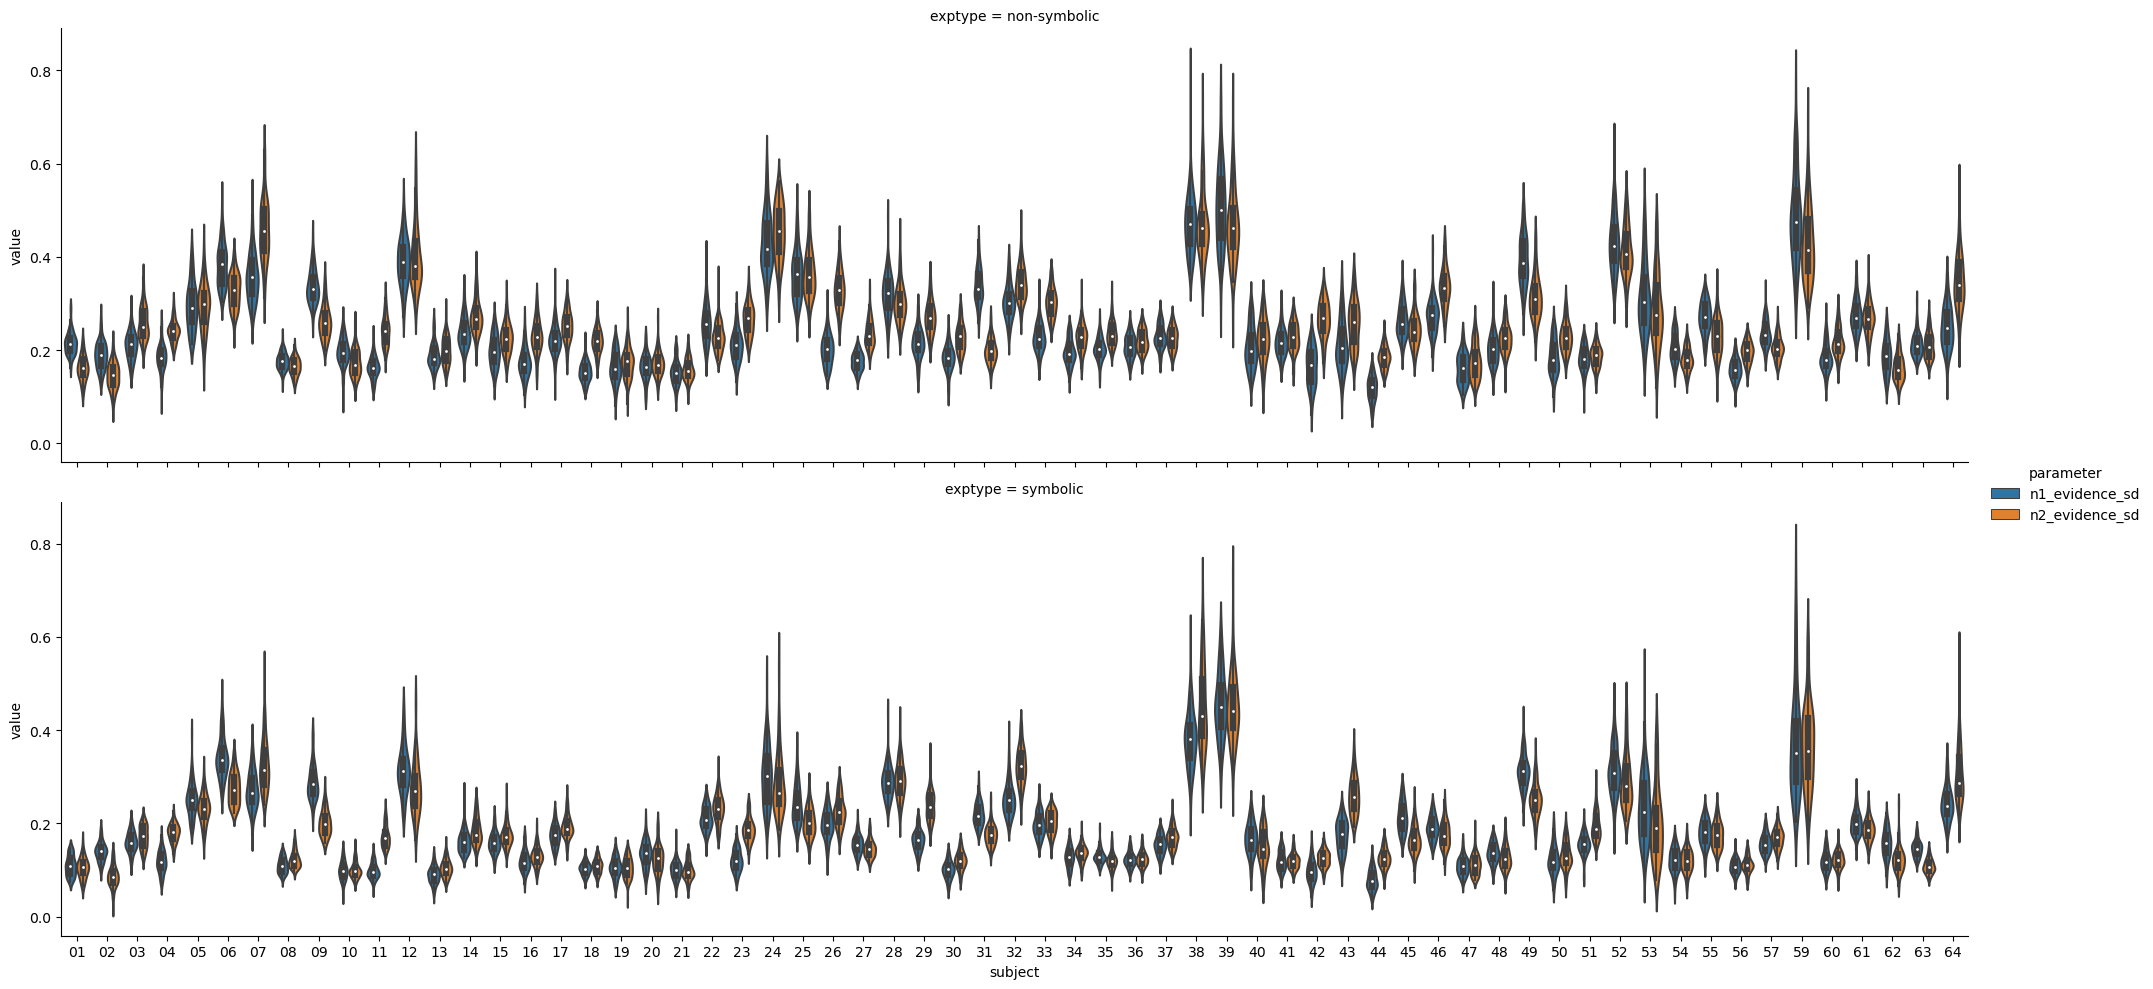

In [23]:
tmp = pd.concat((pars.xs('n1_evidence_sd', 0, -1, drop_level=False), pars.xs('n2_evidence_sd', 0, -1, drop_level=False))).sort_index()

sns.catplot(x='subject', y='value', row='exptype', hue='parameter', data=tmp.reset_index(), kind='violin', aspect=4)
tmp

value
exptype      chain draw subject parameter               
non-symbolic 0     0    01      risky_prior_mu  1.395033
                                safe_prior_mu   2.828109
                        02      risky_prior_mu  1.709603
                                safe_prior_mu   2.008387
                        03      risky_prior_mu  2.241174
...                                                  ...
symbolic     3     26   62      safe_prior_mu   1.813861
                        63      risky_prior_mu  1.884915
                                safe_prior_mu   3.483847
                        64      risky_prior_mu  1.810897
                                safe_prior_mu   3.102764

[20412 rows x 1 columns]

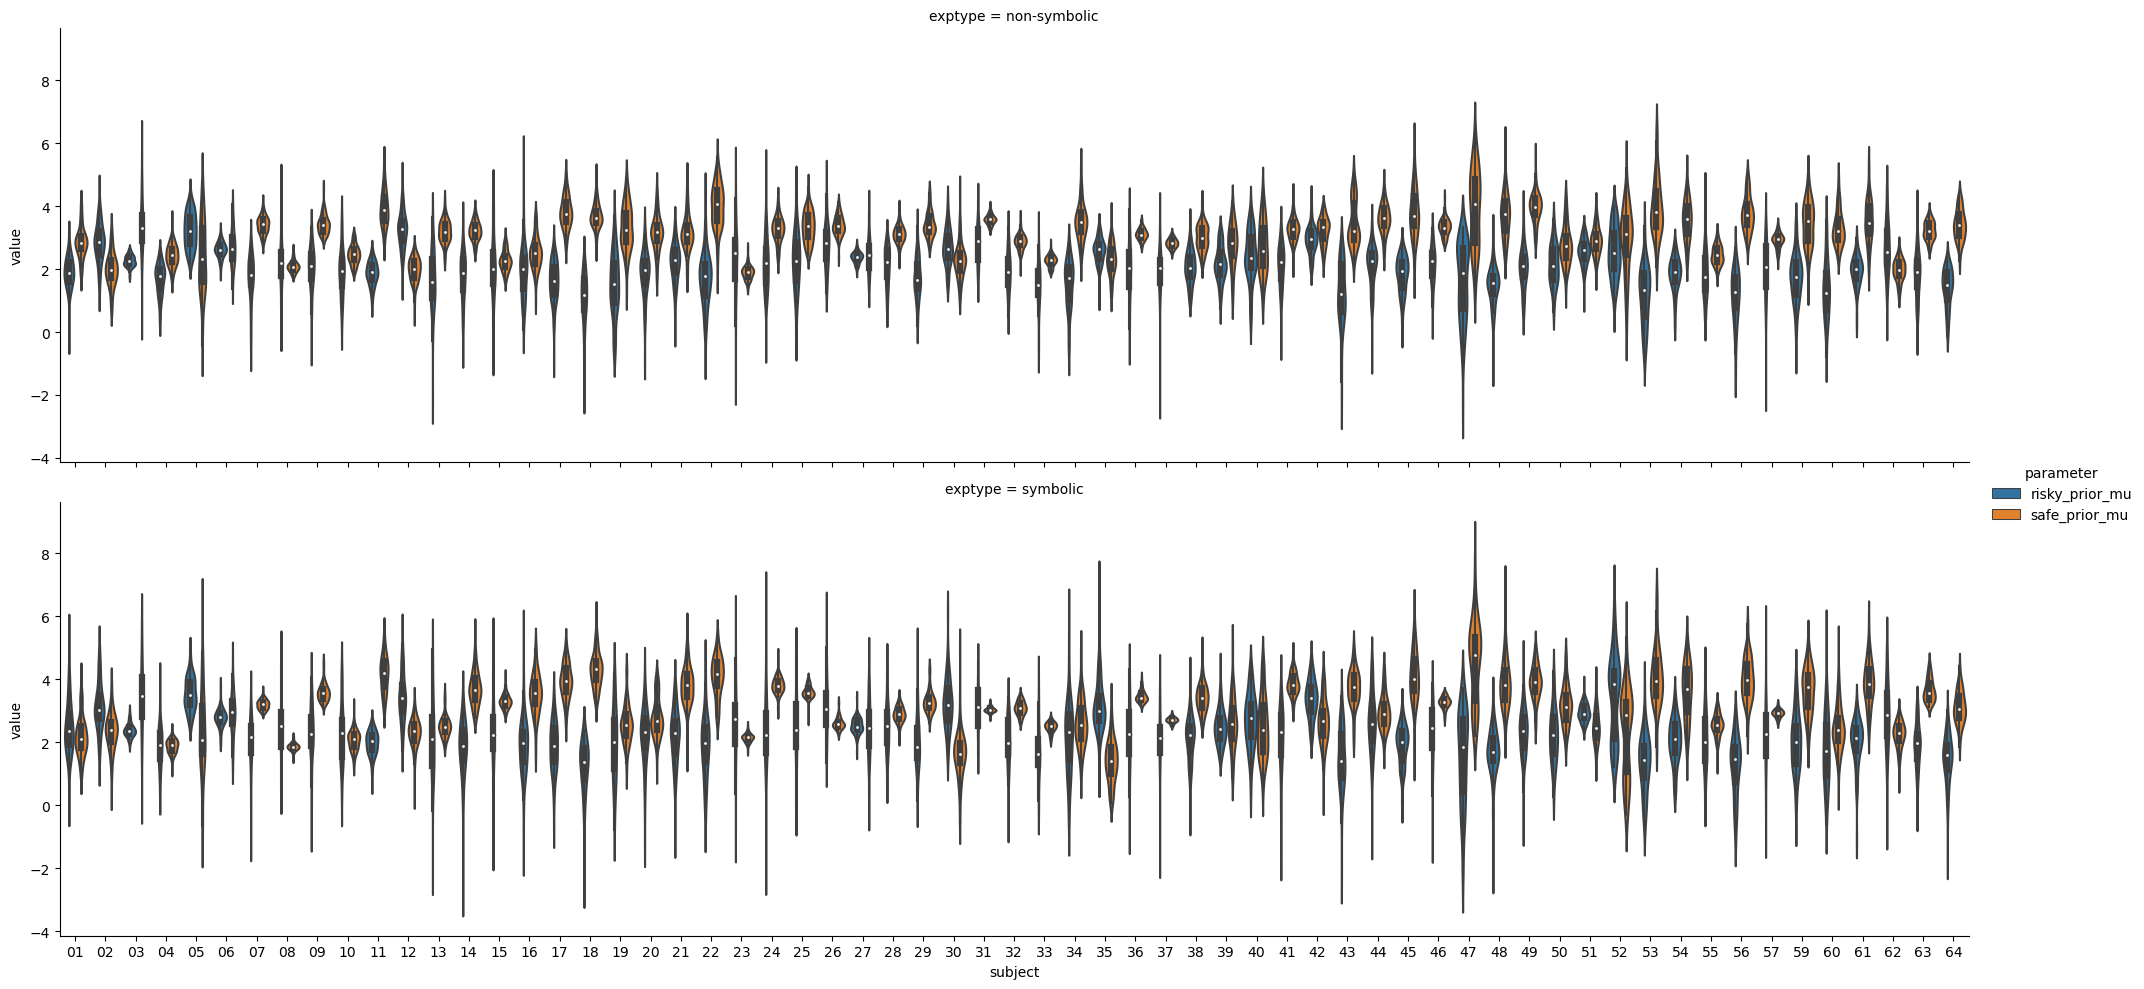

In [24]:
tmp = pd.concat((pars.xs('risky_prior_mu', 0, -1, drop_level=False), pars.xs('safe_prior_mu', 0, -1, drop_level=False))).sort_index()

sns.catplot(x='subject', y='value', row='exptype', hue='parameter', data=tmp.reset_index(), kind='violin', aspect=4)
tmp

# Model 2

In [8]:
df, model, idata = get_info('2')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'n1_evidence_sd_mu'}>,
        <Axes: title={'center': 'n1_evidence_sd_mu'}>],
       [<Axes: title={'center': 'n1_evidence_sd_offset'}>,
        <Axes: title={'center': 'n1_evidence_sd_offset'}>],
       [<Axes: title={'center': 'n2_evidence_sd_mu'}>,
        <Axes: title={'center': 'n2_evidence_sd_mu'}>],
       [<Axes: title={'center': 'n2_evidence_sd_offset'}>,
        <Axes: title={'center': 'n2_evidence_sd_offset'}>],
       [<Axes: title={'center': 'risky_prior_mu_mu'}>,
        <Axes: title={'center': 'risky_prior_mu_mu'}>],
       [<Axes: title={'center': 'risky_prior_mu_offset'}>,
        <Axes: title={'center': 'risky_prior_mu_offset'}>],
       [<Axes: title={'center': 'risky_prior_std_mu'}>,
        <Axes: title={'center': 'risky_prior_std_mu'}>],
       [<Axes: title={'center': 'risky_prior_std_offset'}>,
        <Axes: title={'center': 'risky_prior_std_offset'}>],
       [<Axes: title={'center': 'safe_prior_mu_mu'}>,
        <Axes: title={

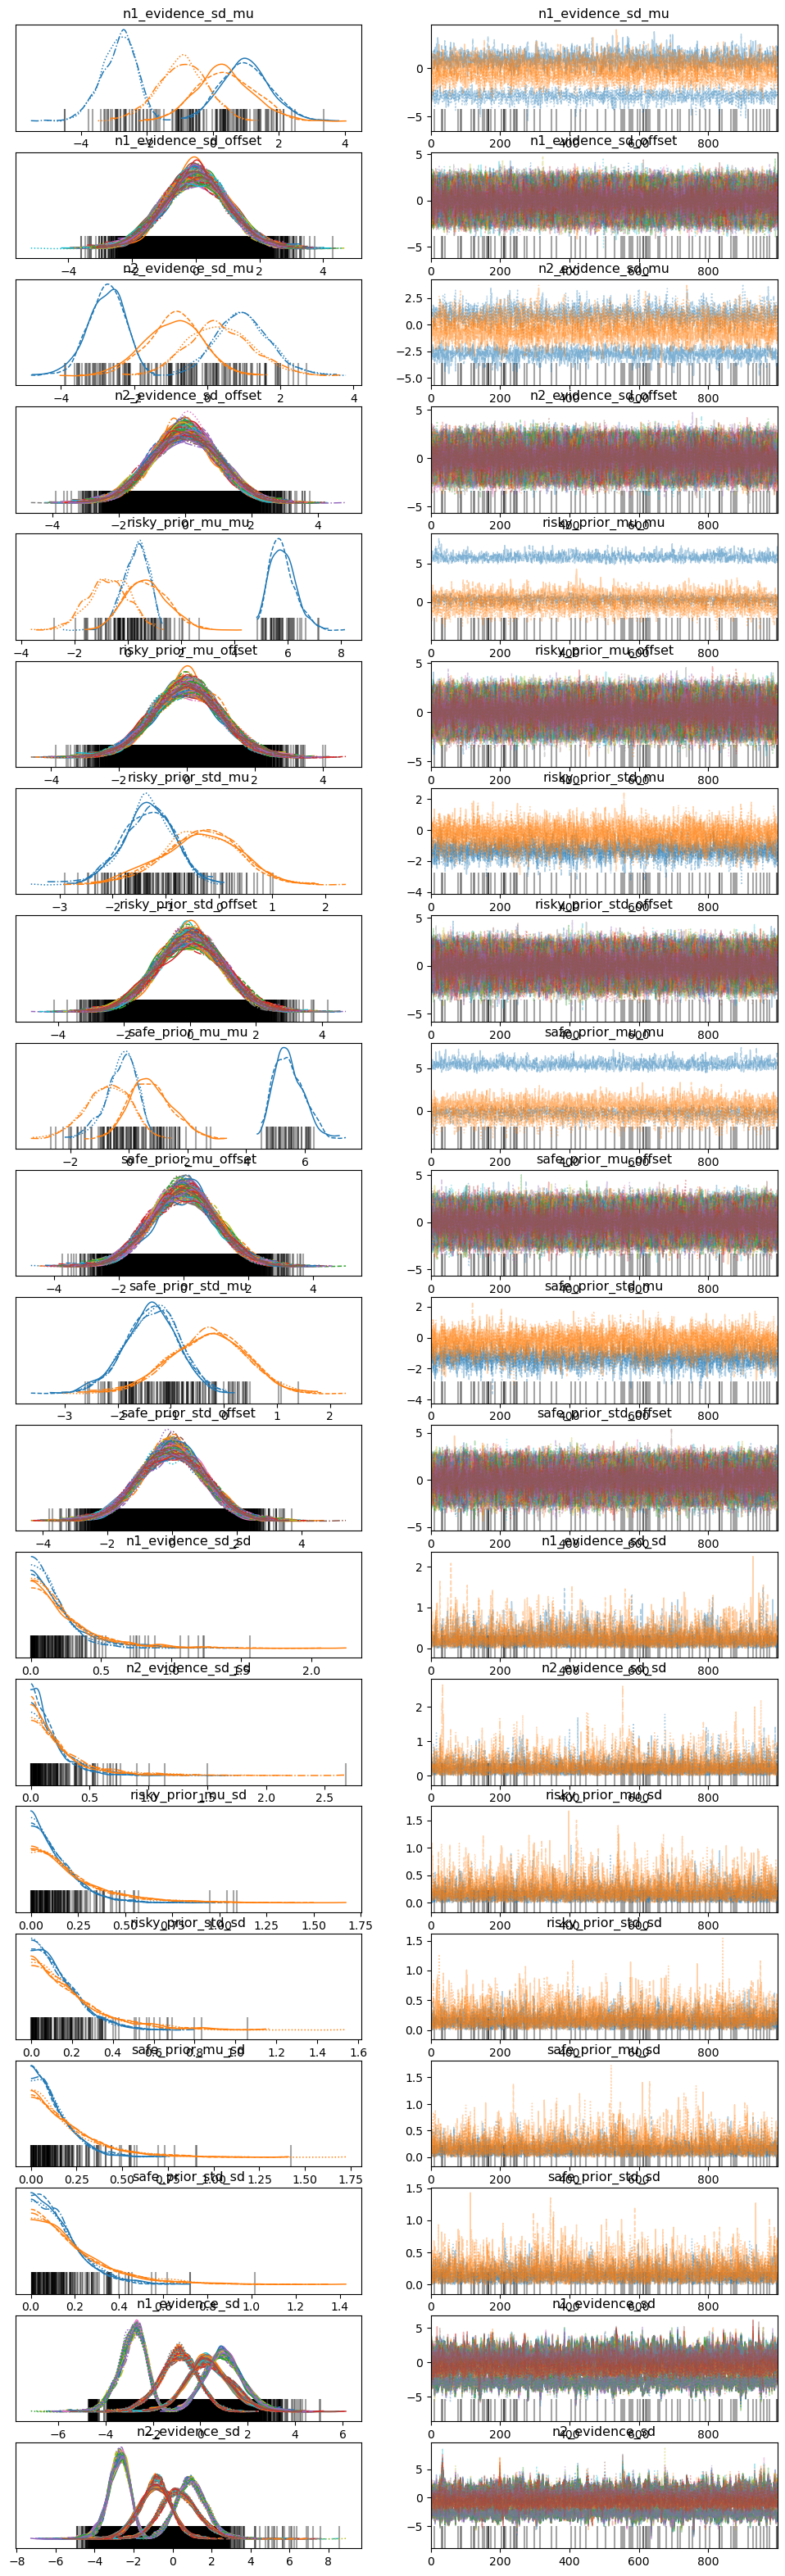

In [16]:
az.plot_trace(idata)

In [31]:
traces = {}

pars_ns = []
pars_s = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.sel(chain=[2]).posterior[f'{key}_mu'].to_dataframe()

    non_symbolic_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    symbolic_values = non_symbolic_values + traces[key].xs('exptype[T.symbolic]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        non_symbolic_values = softplus_np(non_symbolic_values)
        symbolic_values = softplus_np(symbolic_values)

    pars_ns.append(non_symbolic_values)
    pars_s.append(symbolic_values)


pars_ns = pd.concat(pars_ns, axis=1)
pars_s = pd.concat(pars_s, axis=1)

pars = pd.concat((pars_ns, pars_s), keys=['non-symbolic', 'symbolic'], names=['exptype'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


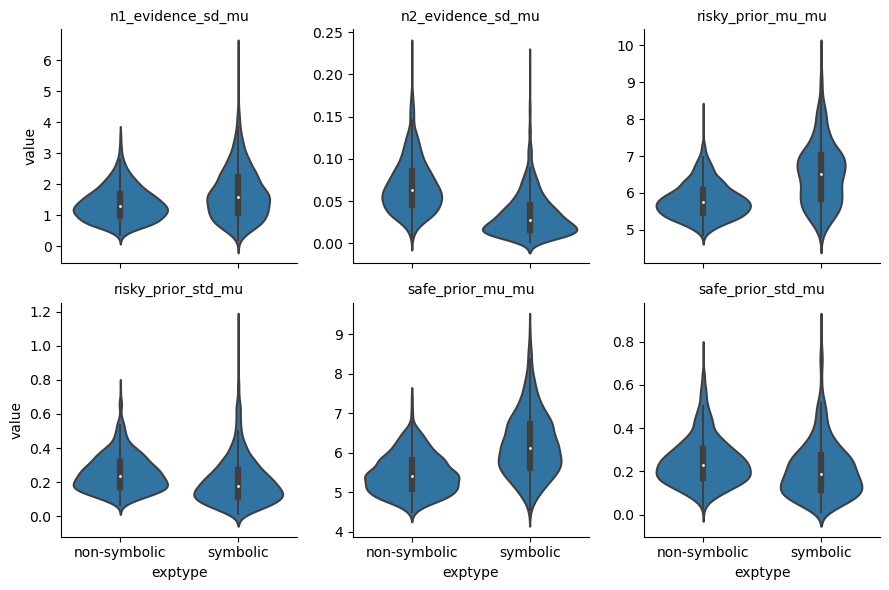

In [32]:
import seaborn as sns

g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'exptype', 'value', fill=True, col_wrap=3)
g.set_titles('{col_name}')

In [34]:
model.build_estimation_model()
ppc = model.ppc(df, idata.sel(draw=slice(None, None, 20)))

Sampling: [ll_bernoulli]


In [35]:
def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5, legend=True, **kwargs):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', 'log(risky/safe)']).size().groupby('subject').size() < 7).all():
        df['log(risky/safe)'] = df.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc = ppc.reset_index('log(risky/safe)')
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')
        ppc.set_index('log(risky/safe)', append=True, inplace=True)

    if plot_type == 0:
        groupby = ['log(risky/safe)', 'Experiment']
    elif plot_type == 1:
        groupby = ['n_safe', 'Experiment']
    elif plot_type in [2, 3]:
        groupby = ['n_safe', 'log(risky/safe)', 'Experiment']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    p = df.groupby(groupby)[['chose_risky']].mean()
    ppc_summary = ppc_summary.join(p).reset_index()

    if 'risky_first' in ppc_summary.columns:
        ppc_summary['Order'] = ppc_summary['risky_first'].map({True:'Risky first', False:'Safe first'})

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [1]:
        x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'


    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Experiment',
                            col_wrap=col_wrap if level == 'subject' else None,
                            hue_order=['Symbols', 'Coin clouds'],
                            palette=sns.color_palette()[-3:],
                            **kwargs)


    elif plot_type in [1]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Experiment',
                            col_wrap=col_wrap if level == 'subject' else None,
                            hue_order=['Symbols', 'Coin clouds'],
                            palette=sns.color_palette()[-3:],
                            **kwargs)

    elif plot_type == 2:
        fac = sns.FacetGrid(ppc_summary,
                            row='subject' if level == 'subject' else None,
                            col='Safe offer',
                            hue='Experiment',
                            hue_order=['Symbols', 'Coin clouds'],
                            palette=sns.color_palette()[-3:],
                            **kwargs)
    elif plot_type == 3:
        fac = sns.FacetGrid(ppc_summary,
                            row='subject' if level == 'subject' else None,
                            col='Experiment',
                            hue='Safe offer',
                            col_order=['Symbols', 'Coin clouds'],
                            palette=sns.color_palette('coolwarm', 6),
                            **kwargs)
    if plot_type in [0, 1,2, 3]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [0, 2, 3]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(3.5, c='k', ls='--'))

    
    if legend:
        fac.add_legend()

    return fac
